In [1]:
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from torch_geometric.data import DataLoader
from tqdm import tqdm

In [7]:
from dataset import COVIDDataset
from st_gnn import SpatioTemporalGCN, TempConv, SpaceConv, PredictLayer

In [10]:
class SpatioTemporalGCN(torch.nn.Module):
    def __init__(self, num_temp_features, num_static_features, d=7):
        super().__init__()
        self.temp_conv = TempConv(num_temp_features * d + num_static_features, 32, 32)
        self.space_conv_1 = SpaceConv(32 + num_static_features, 32, 64)
        self.space_conv_2 = SpaceConv(64 + 32 + num_static_features, 64, 64)
        self.mlp = PredictLayer(64 + 32 + num_static_features, 16, 1)

    def forward(self, x, edge_index, edge_attr):
        x_embed = x
        x_0 = self.temp_conv(x_embed)
        
        x_embed = torch.cat([x_0, x[:, -2:]], dim=-1)
        out = self.space_conv_1(x_embed, edge_attr, edge_index)

        x_embed = torch.cat([out, x_0,  x[:, -2:]], dim=-1)
        out = self.space_conv_2(x_embed, edge_attr, edge_index)

        # readout
        x_embed = torch.cat([out, x_0,  x[:, -2:]], dim=-1)
        out = self.mlp(x_embed)

        # num_counties x 1
        return out

In [ ]:
# load data
train_dataset = COVIDDataset('train')
test_dataset = COVIDDataset('test', normalization_params=train_dataset.normalization_params)

mean, std = test_dataset.normalization_params['y']['mean'], test_dataset.normalization_params['y']['std']

In [31]:
# load model
device = "cpu"
model = SpatioTemporalGCN(num_temp_features=8, num_static_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("models/modeld_%d.pt" % 13000)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [484]:
from torch_geometric.nn import GCNConv, GNNExplainer
import matplotlib.pyplot as plt

Explain node 185: 100%|██████████| 200/200 [00:00<00:00, 253.70it/s]


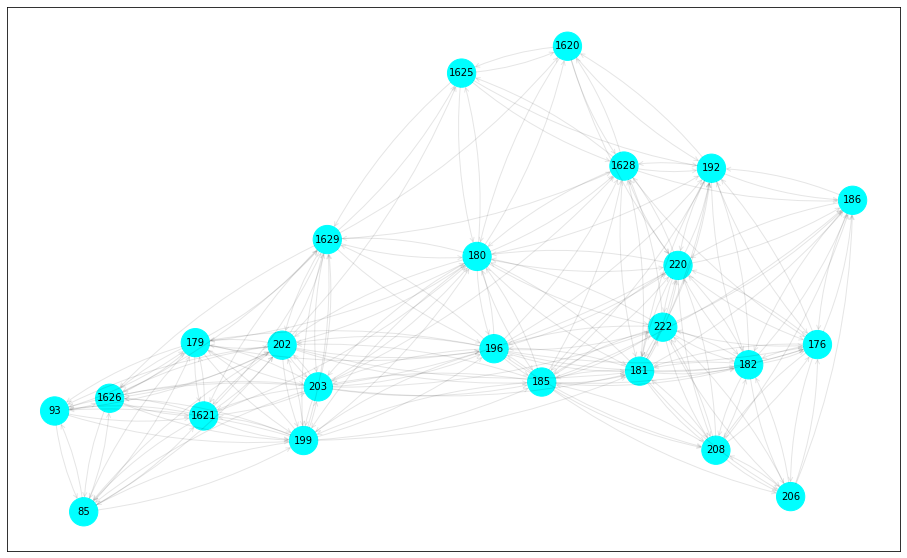

In [485]:
explainer = GNNExplainer(model, epochs=200, num_hops=2)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, torch.cat([data.x, data.sx], dim=-1), data.edge_index, edge_attr=data.edge_attr)
plt.figure(figsize=(16, 10))
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, threshold=0.17)
plt.show()

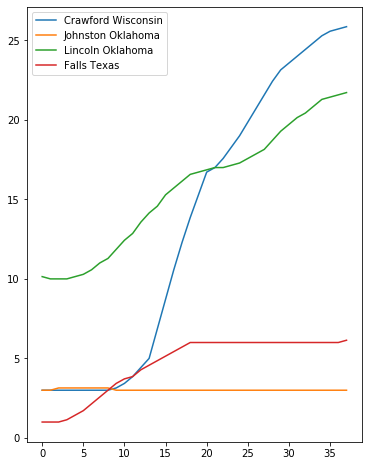

In [498]:
plt.figure(figsize=(6, 8))
plt.plot(test_dataset.y[2859] * std + mean)
plt.plot(test_dataset.y[2016] * std + mean)
plt.plot(test_dataset.y[2022] * std + mean)
plt.plot(test_dataset.y[2427] * std + mean)
plt.legend(['Crawford Wisconsin', 'Johnston Oklahoma', 'Lincoln Oklahoma', 'Falls Texas'])

In [502]:
node_feat_mask

tensor([0.1592, 0.1519, 0.1546, 0.1595, 0.1466, 0.1469, 0.1220, 0.1501, 0.1511,
        0.1401, 0.1486, 0.1546, 0.1612, 0.1412, 0.1503, 0.1497, 0.1542, 0.1396,
        0.1454, 0.1486, 0.1485, 0.1490, 0.1452, 0.1341, 0.1558, 0.1376, 0.1400,
        0.1373, 0.1611, 0.1507, 0.1359, 0.1526, 0.1517, 0.1450, 0.1415, 0.1595,
        0.1579, 0.1603, 0.1422, 0.1473, 0.1505, 0.1574, 0.1464, 0.1550, 0.1473,
        0.1503, 0.1269, 0.1431, 0.1490, 0.1494, 0.1352, 0.1637, 0.1620, 0.1458,
        0.8479, 0.8323, 0.1314, 0.1979])